# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

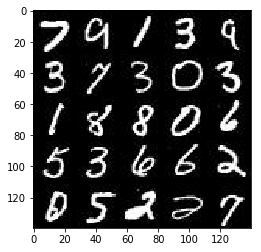

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

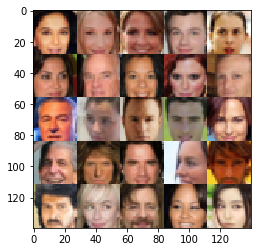

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def LeakyReLU(inputs, alpha=0.2):
    return tf.maximum(inputs * alpha, inputs)

def xavier_init(size, dtype, partition_info):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, dtype=dtype)

def discriminator(images, reuse=False, is_training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding="same", 
                                     activation_fn=None, weights_initializer=xavier_init)
        relu1 = LeakyReLU(x1)
        
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn2 = tf.layers.batch_normalization(x2, training=is_training)
        relu2 = LeakyReLU(bn2)
        
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, stride=2, padding="same",
                                     activation_fn=None, weights_initializer=xavier_init)
        bn3 = tf.layers.batch_normalization(x3, training=is_training)
        relu3 = LeakyReLU(bn3)
        
        flat = tf.contrib.layers.flatten(relu3)
        output = tf.contrib.layers.fully_connected(flat, 1)
    
    return tf.nn.sigmoid(output), output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        
        g = tf.tanh(logits) * 0.5

    return g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    D_real_out, D_real_digits = discriminator(input_real, reuse=False)
    G_model = generator(input_z, out_channel_dim, True)
    D_fake_out, D_fake_digits = discriminator(G_model, reuse=True)
    
    batch_size = input_real.get_shape().as_list()[0]
    print(batch_size)
    if batch_size is None:
        batch_size = 128
    lam = 10
    eps = tf.random_uniform([batch_size, *input_real.get_shape().as_list()[1:]], minval=0., maxval=1.)
    X_inter = eps * input_real + (1 - eps) * G_model
    grad = tf.gradients(discriminator(X_inter, reuse=True)[1], [X_inter])[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum((grad) ** 2, axis=1))
    grad_pen = lam * tf.reduce_mean(grad_norm - 1.) ** 2
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_digits, labels=tf.ones_like(D_real_out)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits, labels=tf.zeros_like(D_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits, labels=tf.ones_like(D_fake_out)))

    d_loss = d_loss_real + d_loss_fake
    
    D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits) + grad_pen
    G_loss = -tf.reduce_mean(D_fake_digits)
    return D_loss, G_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

None
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    g_var = [var for var in variables if var.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,
                                                                                            var_list=d_var)
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,
                                                                                            var_list=g_var)
    """
    D_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_var)
    G_solver = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_var)
    """
    return D_solver, G_solver


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
losses = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          save_folder=None, base_i=0, load_path=None):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_solver, g_solver = model_opt(d_loss, g_loss, lr, beta1)

    if save_folder and not os.path.exists(save_folder):
        os.mkdir(save_folder)

    with tf.Session() as sess:
        print("begin train")
        saver = tf.train.Saver()
        if load_path:
            saver.restore(sess, load_path)
        #tf.summary.FileWriter("./log/train", sess.graph)
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #for d_i in range(2):
                    # train discriminator more
                _ = sess.run(d_solver, feed_dict={input_real: batch_images, 
                                                  input_z: batch_z, 
                                                  lr: learning_rate})

                _ = sess.run(g_solver, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z,
                    lr: learning_rate
                })
                train_loss_d, train_loss_g = sess.run([d_loss, g_loss], feed_dict={
                    input_z: batch_z, input_real:batch_images
                })
                print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                     "Discriminator Loss: {:.4f} ".format(train_loss_d),
                     "Generator Loss: {:.4f}".format(train_loss_g))
                losses.append((train_loss_d, train_loss_g))
            show_generator_output(sess, 8, input_z, data_shape[3], data_image_mode)
            if save_folder:
                saver.save(sess, "{}/{}_gan.ckpt".format(save_folder, epoch_i+base_i))

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

None
begin train
Epoch 1/3 Discriminator Loss: 3.5213  Generator Loss: -4.4697
Epoch 1/3 Discriminator Loss: 1.8718  Generator Loss: -4.1719
Epoch 1/3 Discriminator Loss: 1.0042  Generator Loss: -4.3506
Epoch 1/3 Discriminator Loss: -2.2766  Generator Loss: -2.5397
Epoch 1/3 Discriminator Loss: -2.6676  Generator Loss: -2.9584
Epoch 1/3 Discriminator Loss: -2.6966  Generator Loss: -4.0934
Epoch 1/3 Discriminator Loss: -1.5443  Generator Loss: -6.3160
Epoch 1/3 Discriminator Loss: -1.4019  Generator Loss: -7.2763
Epoch 1/3 Discriminator Loss: 2.3192  Generator Loss: -11.4639
Epoch 1/3 Discriminator Loss: 4.2297  Generator Loss: -13.9628
Epoch 1/3 Discriminator Loss: 4.5969  Generator Loss: -14.9591
Epoch 1/3 Discriminator Loss: 5.6990  Generator Loss: -16.0751
Epoch 1/3 Discriminator Loss: 5.9548  Generator Loss: -16.2126
Epoch 1/3 Discriminator Loss: 5.3367  Generator Loss: -15.2177
Epoch 1/3 Discriminator Loss: 4.4617  Generator Loss: -14.7361
Epoch 1/3 Discriminator Loss: 3.5290  Gen

Epoch 1/3 Discriminator Loss: 2.4091  Generator Loss: -10.9371
Epoch 1/3 Discriminator Loss: 2.4677  Generator Loss: -11.0982
Epoch 1/3 Discriminator Loss: 2.6195  Generator Loss: -11.2716
Epoch 1/3 Discriminator Loss: 2.4943  Generator Loss: -11.3170
Epoch 1/3 Discriminator Loss: 3.1745  Generator Loss: -11.7967
Epoch 1/3 Discriminator Loss: 3.2253  Generator Loss: -12.2087
Epoch 1/3 Discriminator Loss: 3.4164  Generator Loss: -12.6850
Epoch 1/3 Discriminator Loss: 3.5811  Generator Loss: -13.1517
Epoch 1/3 Discriminator Loss: 3.2285  Generator Loss: -12.7469
Epoch 1/3 Discriminator Loss: 2.4056  Generator Loss: -12.2882
Epoch 1/3 Discriminator Loss: 1.8723  Generator Loss: -12.0192
Epoch 1/3 Discriminator Loss: 1.8649  Generator Loss: -11.8331
Epoch 1/3 Discriminator Loss: 1.9160  Generator Loss: -12.3038
Epoch 1/3 Discriminator Loss: 2.8278  Generator Loss: -12.8871
Epoch 1/3 Discriminator Loss: 3.4027  Generator Loss: -13.7265
Epoch 1/3 Discriminator Loss: 3.7723  Generator Loss: -

Epoch 1/3 Discriminator Loss: 2.5091  Generator Loss: -15.9626
Epoch 1/3 Discriminator Loss: 2.7404  Generator Loss: -15.9907
Epoch 1/3 Discriminator Loss: 3.2077  Generator Loss: -16.1029
Epoch 1/3 Discriminator Loss: 3.3569  Generator Loss: -16.0278
Epoch 1/3 Discriminator Loss: 3.3023  Generator Loss: -15.8107
Epoch 1/3 Discriminator Loss: 3.5376  Generator Loss: -15.6611
Epoch 1/3 Discriminator Loss: 3.5115  Generator Loss: -15.3591
Epoch 1/3 Discriminator Loss: 3.0339  Generator Loss: -14.5317
Epoch 1/3 Discriminator Loss: 2.4751  Generator Loss: -13.9198
Epoch 1/3 Discriminator Loss: 2.1029  Generator Loss: -13.4572
Epoch 1/3 Discriminator Loss: 1.7710  Generator Loss: -12.8370
Epoch 1/3 Discriminator Loss: 1.8485  Generator Loss: -12.7203
Epoch 1/3 Discriminator Loss: 2.0747  Generator Loss: -12.9736
Epoch 1/3 Discriminator Loss: 1.4319  Generator Loss: -12.2358
Epoch 1/3 Discriminator Loss: 1.1328  Generator Loss: -12.0401
Epoch 1/3 Discriminator Loss: 1.1771  Generator Loss: -

Epoch 1/3 Discriminator Loss: 1.7721  Generator Loss: -14.3801
Epoch 1/3 Discriminator Loss: 1.7239  Generator Loss: -13.8482
Epoch 1/3 Discriminator Loss: 1.1865  Generator Loss: -13.2036
Epoch 1/3 Discriminator Loss: 1.1388  Generator Loss: -12.6410
Epoch 1/3 Discriminator Loss: 0.4130  Generator Loss: -11.6548
Epoch 1/3 Discriminator Loss: 0.2400  Generator Loss: -11.1309
Epoch 1/3 Discriminator Loss: 0.2269  Generator Loss: -10.7965
Epoch 1/3 Discriminator Loss: -0.0138  Generator Loss: -10.8306
Epoch 1/3 Discriminator Loss: 0.9937  Generator Loss: -11.1372
Epoch 1/3 Discriminator Loss: 0.7611  Generator Loss: -11.4121
Epoch 1/3 Discriminator Loss: 0.7925  Generator Loss: -11.7244
Epoch 1/3 Discriminator Loss: 1.0719  Generator Loss: -12.4040
Epoch 1/3 Discriminator Loss: 1.3876  Generator Loss: -12.7386
Epoch 1/3 Discriminator Loss: 0.9058  Generator Loss: -13.0923
Epoch 1/3 Discriminator Loss: 1.3329  Generator Loss: -13.6313
Epoch 1/3 Discriminator Loss: 1.5382  Generator Loss: 

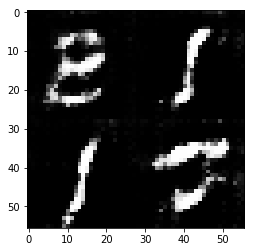

Epoch 2/3 Discriminator Loss: 0.7451  Generator Loss: -12.6652
Epoch 2/3 Discriminator Loss: 0.8127  Generator Loss: -12.5515
Epoch 2/3 Discriminator Loss: 0.7632  Generator Loss: -12.3978
Epoch 2/3 Discriminator Loss: 0.6994  Generator Loss: -12.5052
Epoch 2/3 Discriminator Loss: 0.3263  Generator Loss: -12.2272
Epoch 2/3 Discriminator Loss: 0.5550  Generator Loss: -12.1887
Epoch 2/3 Discriminator Loss: 0.0721  Generator Loss: -11.9940
Epoch 2/3 Discriminator Loss: 0.0614  Generator Loss: -11.8477
Epoch 2/3 Discriminator Loss: 0.2473  Generator Loss: -11.8016
Epoch 2/3 Discriminator Loss: 0.8928  Generator Loss: -12.1108
Epoch 2/3 Discriminator Loss: 0.4038  Generator Loss: -11.8626
Epoch 2/3 Discriminator Loss: 0.4052  Generator Loss: -11.7502
Epoch 2/3 Discriminator Loss: 0.6139  Generator Loss: -12.0136
Epoch 2/3 Discriminator Loss: 0.5651  Generator Loss: -12.2675
Epoch 2/3 Discriminator Loss: 0.8521  Generator Loss: -12.6236
Epoch 2/3 Discriminator Loss: 0.8395  Generator Loss: -

Epoch 2/3 Discriminator Loss: -0.0912  Generator Loss: -12.4206
Epoch 2/3 Discriminator Loss: -0.2644  Generator Loss: -12.3876
Epoch 2/3 Discriminator Loss: -0.2933  Generator Loss: -12.5703
Epoch 2/3 Discriminator Loss: -0.0762  Generator Loss: -12.6968
Epoch 2/3 Discriminator Loss: 0.0850  Generator Loss: -12.8065
Epoch 2/3 Discriminator Loss: 0.2494  Generator Loss: -13.0958
Epoch 2/3 Discriminator Loss: 0.4047  Generator Loss: -13.4666
Epoch 2/3 Discriminator Loss: 0.5645  Generator Loss: -13.6151
Epoch 2/3 Discriminator Loss: 0.7716  Generator Loss: -13.9818
Epoch 2/3 Discriminator Loss: 0.8333  Generator Loss: -14.2900
Epoch 2/3 Discriminator Loss: 0.8236  Generator Loss: -14.5110
Epoch 2/3 Discriminator Loss: 0.7995  Generator Loss: -14.5591
Epoch 2/3 Discriminator Loss: 0.9588  Generator Loss: -14.6628
Epoch 2/3 Discriminator Loss: 0.6905  Generator Loss: -14.3641
Epoch 2/3 Discriminator Loss: 0.1641  Generator Loss: -13.9399
Epoch 2/3 Discriminator Loss: -0.0038  Generator Lo

Epoch 2/3 Discriminator Loss: 0.8516  Generator Loss: -13.3597
Epoch 2/3 Discriminator Loss: 0.9128  Generator Loss: -13.5858
Epoch 2/3 Discriminator Loss: 0.6864  Generator Loss: -13.6570
Epoch 2/3 Discriminator Loss: 0.8729  Generator Loss: -13.9492
Epoch 2/3 Discriminator Loss: 0.5227  Generator Loss: -13.9143
Epoch 2/3 Discriminator Loss: 0.3731  Generator Loss: -13.9289
Epoch 2/3 Discriminator Loss: 0.4752  Generator Loss: -14.1413
Epoch 2/3 Discriminator Loss: 0.3661  Generator Loss: -14.1242
Epoch 2/3 Discriminator Loss: 0.3547  Generator Loss: -14.1237
Epoch 2/3 Discriminator Loss: 0.0166  Generator Loss: -14.2395
Epoch 2/3 Discriminator Loss: 0.4626  Generator Loss: -14.2343
Epoch 2/3 Discriminator Loss: 0.2672  Generator Loss: -14.3147
Epoch 2/3 Discriminator Loss: 0.6405  Generator Loss: -14.5880
Epoch 2/3 Discriminator Loss: 0.6321  Generator Loss: -14.7524
Epoch 2/3 Discriminator Loss: 0.8165  Generator Loss: -14.9352
Epoch 2/3 Discriminator Loss: 0.6567  Generator Loss: -

Epoch 2/3 Discriminator Loss: 0.6516  Generator Loss: -15.9057
Epoch 2/3 Discriminator Loss: 0.7790  Generator Loss: -15.8851
Epoch 2/3 Discriminator Loss: 0.8214  Generator Loss: -15.7358
Epoch 2/3 Discriminator Loss: 0.8507  Generator Loss: -15.6463
Epoch 2/3 Discriminator Loss: 0.8243  Generator Loss: -15.6266
Epoch 2/3 Discriminator Loss: 0.6987  Generator Loss: -15.4145
Epoch 2/3 Discriminator Loss: 0.3953  Generator Loss: -14.9909
Epoch 2/3 Discriminator Loss: 0.4841  Generator Loss: -14.8993
Epoch 2/3 Discriminator Loss: 0.1657  Generator Loss: -14.8421
Epoch 2/3 Discriminator Loss: 0.5726  Generator Loss: -14.7425
Epoch 2/3 Discriminator Loss: 0.4039  Generator Loss: -14.7354
Epoch 2/3 Discriminator Loss: 0.3470  Generator Loss: -14.6410
Epoch 2/3 Discriminator Loss: 0.2112  Generator Loss: -14.5848
Epoch 2/3 Discriminator Loss: -0.2027  Generator Loss: -14.4602
Epoch 2/3 Discriminator Loss: -0.1716  Generator Loss: -14.4565
Epoch 2/3 Discriminator Loss: -0.0977  Generator Loss

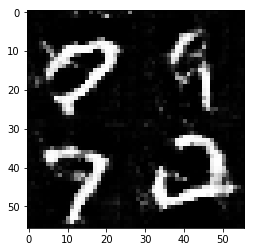

Epoch 3/3 Discriminator Loss: 0.7960  Generator Loss: -14.8315
Epoch 3/3 Discriminator Loss: 0.8102  Generator Loss: -14.9573
Epoch 3/3 Discriminator Loss: 0.6178  Generator Loss: -15.1753
Epoch 3/3 Discriminator Loss: 0.6836  Generator Loss: -15.5440
Epoch 3/3 Discriminator Loss: 0.6320  Generator Loss: -15.8015
Epoch 3/3 Discriminator Loss: 0.7821  Generator Loss: -16.2042
Epoch 3/3 Discriminator Loss: 0.4400  Generator Loss: -16.2134
Epoch 3/3 Discriminator Loss: 0.7190  Generator Loss: -16.4067
Epoch 3/3 Discriminator Loss: 0.4263  Generator Loss: -16.3803
Epoch 3/3 Discriminator Loss: 0.3911  Generator Loss: -16.3064
Epoch 3/3 Discriminator Loss: 0.3866  Generator Loss: -16.5800
Epoch 3/3 Discriminator Loss: 0.5967  Generator Loss: -16.4893
Epoch 3/3 Discriminator Loss: 0.6002  Generator Loss: -16.4304
Epoch 3/3 Discriminator Loss: 0.5541  Generator Loss: -16.0841
Epoch 3/3 Discriminator Loss: 0.4412  Generator Loss: -15.8584
Epoch 3/3 Discriminator Loss: 0.4719  Generator Loss: -

Epoch 3/3 Discriminator Loss: 0.6594  Generator Loss: -17.7232
Epoch 3/3 Discriminator Loss: 0.6074  Generator Loss: -17.7853
Epoch 3/3 Discriminator Loss: 0.0351  Generator Loss: -17.4101
Epoch 3/3 Discriminator Loss: 0.3459  Generator Loss: -17.4927
Epoch 3/3 Discriminator Loss: 0.1970  Generator Loss: -16.9906
Epoch 3/3 Discriminator Loss: 0.2524  Generator Loss: -16.9090
Epoch 3/3 Discriminator Loss: -0.1372  Generator Loss: -16.5862
Epoch 3/3 Discriminator Loss: 0.1545  Generator Loss: -16.6016
Epoch 3/3 Discriminator Loss: 0.3386  Generator Loss: -16.4936
Epoch 3/3 Discriminator Loss: 0.4972  Generator Loss: -16.5369
Epoch 3/3 Discriminator Loss: 0.4548  Generator Loss: -16.4984
Epoch 3/3 Discriminator Loss: 0.6364  Generator Loss: -16.4042
Epoch 3/3 Discriminator Loss: 0.4080  Generator Loss: -16.1898
Epoch 3/3 Discriminator Loss: 0.7565  Generator Loss: -16.3172
Epoch 3/3 Discriminator Loss: 0.5458  Generator Loss: -16.2566
Epoch 3/3 Discriminator Loss: 0.4788  Generator Loss: 

Epoch 3/3 Discriminator Loss: -0.0040  Generator Loss: -16.0654
Epoch 3/3 Discriminator Loss: 0.3763  Generator Loss: -17.0690
Epoch 3/3 Discriminator Loss: 0.5147  Generator Loss: -17.4822
Epoch 3/3 Discriminator Loss: 0.9449  Generator Loss: -17.6402
Epoch 3/3 Discriminator Loss: 0.5511  Generator Loss: -17.1170
Epoch 3/3 Discriminator Loss: 0.5388  Generator Loss: -17.1117
Epoch 3/3 Discriminator Loss: 0.6526  Generator Loss: -17.3256
Epoch 3/3 Discriminator Loss: 0.5895  Generator Loss: -17.1566
Epoch 3/3 Discriminator Loss: 0.2912  Generator Loss: -17.0695
Epoch 3/3 Discriminator Loss: 0.5200  Generator Loss: -17.1760
Epoch 3/3 Discriminator Loss: 0.3603  Generator Loss: -17.1002
Epoch 3/3 Discriminator Loss: 0.4899  Generator Loss: -17.1908
Epoch 3/3 Discriminator Loss: 0.4475  Generator Loss: -17.2467
Epoch 3/3 Discriminator Loss: 0.4535  Generator Loss: -17.2525
Epoch 3/3 Discriminator Loss: 0.3779  Generator Loss: -17.3234
Epoch 3/3 Discriminator Loss: 0.3266  Generator Loss: 

Epoch 3/3 Discriminator Loss: 0.4067  Generator Loss: -17.0348
Epoch 3/3 Discriminator Loss: 0.3256  Generator Loss: -17.0620
Epoch 3/3 Discriminator Loss: 0.4581  Generator Loss: -17.3182
Epoch 3/3 Discriminator Loss: 0.2094  Generator Loss: -17.2675
Epoch 3/3 Discriminator Loss: 0.2896  Generator Loss: -17.3579
Epoch 3/3 Discriminator Loss: 0.3153  Generator Loss: -17.5573
Epoch 3/3 Discriminator Loss: 0.3703  Generator Loss: -17.9097
Epoch 3/3 Discriminator Loss: 0.3805  Generator Loss: -18.0613
Epoch 3/3 Discriminator Loss: 0.4293  Generator Loss: -18.2942
Epoch 3/3 Discriminator Loss: 0.5098  Generator Loss: -18.5538
Epoch 3/3 Discriminator Loss: 0.6070  Generator Loss: -18.6010
Epoch 3/3 Discriminator Loss: 0.6082  Generator Loss: -18.6123
Epoch 3/3 Discriminator Loss: 0.5778  Generator Loss: -18.5980
Epoch 3/3 Discriminator Loss: 0.5934  Generator Loss: -18.4765
Epoch 3/3 Discriminator Loss: 0.3859  Generator Loss: -18.1186
Epoch 3/3 Discriminator Loss: 0.2370  Generator Loss: -

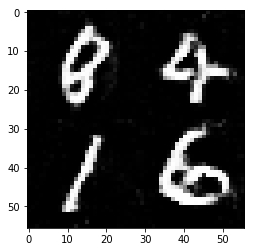

In [ ]:
batch_size = 128
z_dim = 10
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3
save_path = "mnist_save"

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_path)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

None
begin train
INFO:tensorflow:Restoring parameters from celeba_save/2_gan.ckpt
Epoch 1/10 Discriminator Loss: 1.1525  Generator Loss: -9.5932
Epoch 1/10 Discriminator Loss: 1.0721  Generator Loss: -9.5640
Epoch 1/10 Discriminator Loss: 1.1376  Generator Loss: -9.5843
Epoch 1/10 Discriminator Loss: 1.0955  Generator Loss: -9.5765
Epoch 1/10 Discriminator Loss: 1.3750  Generator Loss: -9.5743
Epoch 1/10 Discriminator Loss: 1.3129  Generator Loss: -9.5550
Epoch 1/10 Discriminator Loss: 1.0720  Generator Loss: -9.4952
Epoch 1/10 Discriminator Loss: 1.0217  Generator Loss: -9.3865
Epoch 1/10 Discriminator Loss: 1.0186  Generator Loss: -9.4611
Epoch 1/10 Discriminator Loss: 1.3005  Generator Loss: -9.4713
Epoch 1/10 Discriminator Loss: 1.1853  Generator Loss: -9.5047
Epoch 1/10 Discriminator Loss: 1.2544  Generator Loss: -9.5571
Epoch 1/10 Discriminator Loss: 1.2840  Generator Loss: -9.5132
Epoch 1/10 Discriminator Loss: 1.2346  Generator Loss: -9.5236
Epoch 1/10 Discriminator Loss: 1.196

Epoch 1/10 Discriminator Loss: 1.0121  Generator Loss: -8.6201
Epoch 1/10 Discriminator Loss: 0.9712  Generator Loss: -8.6245
Epoch 1/10 Discriminator Loss: 0.8901  Generator Loss: -8.5885
Epoch 1/10 Discriminator Loss: 1.0314  Generator Loss: -8.6029
Epoch 1/10 Discriminator Loss: 1.0439  Generator Loss: -8.6404
Epoch 1/10 Discriminator Loss: 1.0070  Generator Loss: -8.6202
Epoch 1/10 Discriminator Loss: 1.0548  Generator Loss: -8.5847
Epoch 1/10 Discriminator Loss: 0.8668  Generator Loss: -8.5076
Epoch 1/10 Discriminator Loss: 0.9967  Generator Loss: -8.5296
Epoch 1/10 Discriminator Loss: 0.9254  Generator Loss: -8.6160
Epoch 1/10 Discriminator Loss: 0.9563  Generator Loss: -8.6141
Epoch 1/10 Discriminator Loss: 0.9719  Generator Loss: -8.5835
Epoch 1/10 Discriminator Loss: 0.8853  Generator Loss: -8.5472
Epoch 1/10 Discriminator Loss: 0.9278  Generator Loss: -8.4792
Epoch 1/10 Discriminator Loss: 0.9256  Generator Loss: -8.5260
Epoch 1/10 Discriminator Loss: 1.0454  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.7687  Generator Loss: -7.5614
Epoch 1/10 Discriminator Loss: 0.7704  Generator Loss: -7.5645
Epoch 1/10 Discriminator Loss: 0.8635  Generator Loss: -7.5168
Epoch 1/10 Discriminator Loss: 0.7904  Generator Loss: -7.5226
Epoch 1/10 Discriminator Loss: 0.7498  Generator Loss: -7.5049
Epoch 1/10 Discriminator Loss: 0.8715  Generator Loss: -7.5322
Epoch 1/10 Discriminator Loss: 0.8558  Generator Loss: -7.5755
Epoch 1/10 Discriminator Loss: 0.8736  Generator Loss: -7.5444
Epoch 1/10 Discriminator Loss: 0.7944  Generator Loss: -7.4617
Epoch 1/10 Discriminator Loss: 0.7542  Generator Loss: -7.4941
Epoch 1/10 Discriminator Loss: 0.8683  Generator Loss: -7.5538
Epoch 1/10 Discriminator Loss: 0.8433  Generator Loss: -7.5274
Epoch 1/10 Discriminator Loss: 0.8648  Generator Loss: -7.5030
Epoch 1/10 Discriminator Loss: 0.7297  Generator Loss: -7.4751
Epoch 1/10 Discriminator Loss: 0.7078  Generator Loss: -7.4231
Epoch 1/10 Discriminator Loss: 0.8402  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.8685  Generator Loss: -7.0933
Epoch 1/10 Discriminator Loss: 0.8077  Generator Loss: -7.0785
Epoch 1/10 Discriminator Loss: 0.7388  Generator Loss: -7.0579
Epoch 1/10 Discriminator Loss: 0.7362  Generator Loss: -7.0947
Epoch 1/10 Discriminator Loss: 0.8696  Generator Loss: -7.0961
Epoch 1/10 Discriminator Loss: 0.8069  Generator Loss: -6.9970
Epoch 1/10 Discriminator Loss: 0.8406  Generator Loss: -7.0393
Epoch 1/10 Discriminator Loss: 0.7564  Generator Loss: -7.0343
Epoch 1/10 Discriminator Loss: 0.7812  Generator Loss: -6.9659
Epoch 1/10 Discriminator Loss: 0.8505  Generator Loss: -7.0480
Epoch 1/10 Discriminator Loss: 0.8669  Generator Loss: -7.0210
Epoch 1/10 Discriminator Loss: 1.1901  Generator Loss: -6.9272
Epoch 1/10 Discriminator Loss: 0.7861  Generator Loss: -7.0079
Epoch 1/10 Discriminator Loss: 0.7707  Generator Loss: -7.0418
Epoch 1/10 Discriminator Loss: 0.7778  Generator Loss: -7.0293
Epoch 1/10 Discriminator Loss: 0.7904  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.6048  Generator Loss: -6.3138
Epoch 1/10 Discriminator Loss: 0.7207  Generator Loss: -6.3214
Epoch 1/10 Discriminator Loss: 0.7655  Generator Loss: -6.3296
Epoch 1/10 Discriminator Loss: 0.6582  Generator Loss: -6.3547
Epoch 1/10 Discriminator Loss: 0.6881  Generator Loss: -6.3695
Epoch 1/10 Discriminator Loss: 0.6363  Generator Loss: -6.3412
Epoch 1/10 Discriminator Loss: 0.6030  Generator Loss: -6.3344
Epoch 1/10 Discriminator Loss: 0.5558  Generator Loss: -6.2785
Epoch 1/10 Discriminator Loss: 0.5214  Generator Loss: -6.2819
Epoch 1/10 Discriminator Loss: 0.5575  Generator Loss: -6.2968
Epoch 1/10 Discriminator Loss: 0.5739  Generator Loss: -6.3325
Epoch 1/10 Discriminator Loss: 0.6409  Generator Loss: -6.3441
Epoch 1/10 Discriminator Loss: 0.6341  Generator Loss: -6.3399
Epoch 1/10 Discriminator Loss: 0.5267  Generator Loss: -6.2989
Epoch 1/10 Discriminator Loss: 0.5066  Generator Loss: -6.1558
Epoch 1/10 Discriminator Loss: 0.7746  Generator Loss: 

Epoch 1/10 Discriminator Loss: 1.0743  Generator Loss: -5.8100
Epoch 1/10 Discriminator Loss: 0.5477  Generator Loss: -5.7996
Epoch 1/10 Discriminator Loss: 0.6378  Generator Loss: -5.8043
Epoch 1/10 Discriminator Loss: 0.6430  Generator Loss: -5.8230
Epoch 1/10 Discriminator Loss: 0.7120  Generator Loss: -5.8374
Epoch 1/10 Discriminator Loss: 0.6006  Generator Loss: -5.8031
Epoch 1/10 Discriminator Loss: 0.5484  Generator Loss: -5.7949
Epoch 1/10 Discriminator Loss: 0.6226  Generator Loss: -5.7744
Epoch 1/10 Discriminator Loss: 0.5944  Generator Loss: -5.7900
Epoch 1/10 Discriminator Loss: 0.6156  Generator Loss: -5.7761
Epoch 1/10 Discriminator Loss: 0.4934  Generator Loss: -5.7070
Epoch 1/10 Discriminator Loss: 0.4605  Generator Loss: -5.6294
Epoch 1/10 Discriminator Loss: 0.5782  Generator Loss: -5.7255
Epoch 1/10 Discriminator Loss: 0.7013  Generator Loss: -5.7474
Epoch 1/10 Discriminator Loss: 0.5648  Generator Loss: -5.7241
Epoch 1/10 Discriminator Loss: 0.5845  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.5512  Generator Loss: -5.6330
Epoch 1/10 Discriminator Loss: 0.5809  Generator Loss: -5.6372
Epoch 1/10 Discriminator Loss: 0.5614  Generator Loss: -5.6406
Epoch 1/10 Discriminator Loss: 0.5097  Generator Loss: -5.5532
Epoch 1/10 Discriminator Loss: 0.4351  Generator Loss: -5.5292
Epoch 1/10 Discriminator Loss: 0.6259  Generator Loss: -5.5144
Epoch 1/10 Discriminator Loss: 0.7779  Generator Loss: -5.6243
Epoch 1/10 Discriminator Loss: 0.5639  Generator Loss: -5.5920
Epoch 1/10 Discriminator Loss: 0.5196  Generator Loss: -5.5686
Epoch 1/10 Discriminator Loss: 0.4918  Generator Loss: -5.5902
Epoch 1/10 Discriminator Loss: 0.4907  Generator Loss: -5.6128
Epoch 1/10 Discriminator Loss: 0.6139  Generator Loss: -5.6268
Epoch 1/10 Discriminator Loss: 0.5740  Generator Loss: -5.6060
Epoch 1/10 Discriminator Loss: 0.5183  Generator Loss: -5.5932
Epoch 1/10 Discriminator Loss: 0.4563  Generator Loss: -5.5220
Epoch 1/10 Discriminator Loss: 0.5673  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.4999  Generator Loss: -5.4519
Epoch 1/10 Discriminator Loss: 0.3826  Generator Loss: -5.3309
Epoch 1/10 Discriminator Loss: 0.5710  Generator Loss: -5.3629
Epoch 1/10 Discriminator Loss: 0.6066  Generator Loss: -5.4506
Epoch 1/10 Discriminator Loss: 0.5224  Generator Loss: -5.4790
Epoch 1/10 Discriminator Loss: 0.4266  Generator Loss: -5.4759
Epoch 1/10 Discriminator Loss: 0.5313  Generator Loss: -5.4909
Epoch 1/10 Discriminator Loss: 0.6024  Generator Loss: -5.5124
Epoch 1/10 Discriminator Loss: 0.4867  Generator Loss: -5.5082
Epoch 1/10 Discriminator Loss: 0.4836  Generator Loss: -5.5162
Epoch 1/10 Discriminator Loss: 0.4707  Generator Loss: -5.4412
Epoch 1/10 Discriminator Loss: 0.3700  Generator Loss: -5.3843
Epoch 1/10 Discriminator Loss: 0.6376  Generator Loss: -5.4676
Epoch 1/10 Discriminator Loss: 0.5817  Generator Loss: -5.5196
Epoch 1/10 Discriminator Loss: 0.4945  Generator Loss: -5.5212
Epoch 1/10 Discriminator Loss: 0.6429  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.3993  Generator Loss: -5.0318
Epoch 1/10 Discriminator Loss: 0.4400  Generator Loss: -5.0812
Epoch 1/10 Discriminator Loss: 0.4780  Generator Loss: -5.0681
Epoch 1/10 Discriminator Loss: 0.5575  Generator Loss: -5.0626
Epoch 1/10 Discriminator Loss: 0.5106  Generator Loss: -5.0878
Epoch 1/10 Discriminator Loss: 0.5512  Generator Loss: -5.0573
Epoch 1/10 Discriminator Loss: 0.4906  Generator Loss: -5.0504
Epoch 1/10 Discriminator Loss: 0.5988  Generator Loss: -5.0409
Epoch 1/10 Discriminator Loss: 0.4466  Generator Loss: -5.0313
Epoch 1/10 Discriminator Loss: 0.4561  Generator Loss: -5.0432
Epoch 1/10 Discriminator Loss: 0.4841  Generator Loss: -5.0319
Epoch 1/10 Discriminator Loss: 0.4990  Generator Loss: -5.0365
Epoch 1/10 Discriminator Loss: 0.5111  Generator Loss: -5.0294
Epoch 1/10 Discriminator Loss: 0.4097  Generator Loss: -5.0181
Epoch 1/10 Discriminator Loss: 0.3593  Generator Loss: -4.9657
Epoch 1/10 Discriminator Loss: 0.3445  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.4248  Generator Loss: -4.7443
Epoch 1/10 Discriminator Loss: 0.4401  Generator Loss: -4.7313
Epoch 1/10 Discriminator Loss: 0.4995  Generator Loss: -4.7397
Epoch 1/10 Discriminator Loss: 0.4076  Generator Loss: -4.7193
Epoch 1/10 Discriminator Loss: 0.4587  Generator Loss: -4.6664
Epoch 1/10 Discriminator Loss: 0.4161  Generator Loss: -4.6687
Epoch 1/10 Discriminator Loss: 0.3869  Generator Loss: -4.6857
Epoch 1/10 Discriminator Loss: 0.4453  Generator Loss: -4.6988
Epoch 1/10 Discriminator Loss: 0.3758  Generator Loss: -4.7034
Epoch 1/10 Discriminator Loss: 0.4611  Generator Loss: -4.6966
Epoch 1/10 Discriminator Loss: 0.4823  Generator Loss: -4.6870
Epoch 1/10 Discriminator Loss: 0.5552  Generator Loss: -4.6651
Epoch 1/10 Discriminator Loss: 0.4373  Generator Loss: -4.6904
Epoch 1/10 Discriminator Loss: 0.4601  Generator Loss: -4.6944
Epoch 1/10 Discriminator Loss: 0.4164  Generator Loss: -4.6832
Epoch 1/10 Discriminator Loss: 0.5063  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.3980  Generator Loss: -4.4738
Epoch 1/10 Discriminator Loss: 0.4901  Generator Loss: -4.4857
Epoch 1/10 Discriminator Loss: 0.4823  Generator Loss: -4.4760
Epoch 1/10 Discriminator Loss: 0.4215  Generator Loss: -4.4641
Epoch 1/10 Discriminator Loss: 0.4878  Generator Loss: -4.4664
Epoch 1/10 Discriminator Loss: 0.5260  Generator Loss: -4.4697
Epoch 1/10 Discriminator Loss: 0.3899  Generator Loss: -4.4700
Epoch 1/10 Discriminator Loss: 0.4707  Generator Loss: -4.4511
Epoch 1/10 Discriminator Loss: 0.4115  Generator Loss: -4.4334
Epoch 1/10 Discriminator Loss: 0.4360  Generator Loss: -4.3959
Epoch 1/10 Discriminator Loss: 0.3696  Generator Loss: -4.4245
Epoch 1/10 Discriminator Loss: 0.4504  Generator Loss: -4.4452
Epoch 1/10 Discriminator Loss: 0.4669  Generator Loss: -4.4429
Epoch 1/10 Discriminator Loss: 0.4341  Generator Loss: -4.4501
Epoch 1/10 Discriminator Loss: 0.4396  Generator Loss: -4.4328
Epoch 1/10 Discriminator Loss: 0.4450  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.3549  Generator Loss: -4.1968
Epoch 1/10 Discriminator Loss: 0.3924  Generator Loss: -4.2048
Epoch 1/10 Discriminator Loss: 0.3642  Generator Loss: -4.1731
Epoch 1/10 Discriminator Loss: 0.3394  Generator Loss: -4.1575
Epoch 1/10 Discriminator Loss: 0.3642  Generator Loss: -4.1630
Epoch 1/10 Discriminator Loss: 0.3705  Generator Loss: -4.1511
Epoch 1/10 Discriminator Loss: 0.3793  Generator Loss: -4.1659
Epoch 1/10 Discriminator Loss: 0.3945  Generator Loss: -4.1742
Epoch 1/10 Discriminator Loss: 0.4435  Generator Loss: -4.1912
Epoch 1/10 Discriminator Loss: 0.3802  Generator Loss: -4.1796
Epoch 1/10 Discriminator Loss: 0.3072  Generator Loss: -4.1710
Epoch 1/10 Discriminator Loss: 0.3008  Generator Loss: -4.1210
Epoch 1/10 Discriminator Loss: 0.3414  Generator Loss: -4.1257
Epoch 1/10 Discriminator Loss: 0.4413  Generator Loss: -4.1779
Epoch 1/10 Discriminator Loss: 0.4251  Generator Loss: -4.1912
Epoch 1/10 Discriminator Loss: 0.4310  Generator Loss: 

Epoch 1/10 Discriminator Loss: 0.2983  Generator Loss: -3.9759
Epoch 1/10 Discriminator Loss: 0.3563  Generator Loss: -3.9781
Epoch 1/10 Discriminator Loss: 0.3337  Generator Loss: -3.9637
Epoch 1/10 Discriminator Loss: 0.3358  Generator Loss: -3.9636
Epoch 1/10 Discriminator Loss: 0.3122  Generator Loss: -3.9526
Epoch 1/10 Discriminator Loss: 0.3569  Generator Loss: -3.9409
Epoch 1/10 Discriminator Loss: 0.2246  Generator Loss: -3.8348
Epoch 1/10 Discriminator Loss: 0.5341  Generator Loss: -3.9170
Epoch 1/10 Discriminator Loss: 0.3099  Generator Loss: -3.9170
Epoch 1/10 Discriminator Loss: 0.4125  Generator Loss: -3.9297
Epoch 1/10 Discriminator Loss: 0.3744  Generator Loss: -3.9303
Epoch 1/10 Discriminator Loss: 0.3550  Generator Loss: -3.9259


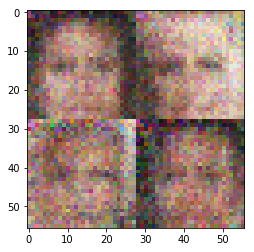

Epoch 2/10 Discriminator Loss: 0.3707  Generator Loss: -3.9328
Epoch 2/10 Discriminator Loss: 0.3232  Generator Loss: -3.9367
Epoch 2/10 Discriminator Loss: 0.3142  Generator Loss: -3.9387
Epoch 2/10 Discriminator Loss: 0.3255  Generator Loss: -3.9397
Epoch 2/10 Discriminator Loss: 0.4291  Generator Loss: -3.9364
Epoch 2/10 Discriminator Loss: 0.3861  Generator Loss: -3.9125
Epoch 2/10 Discriminator Loss: 0.3656  Generator Loss: -3.9102
Epoch 2/10 Discriminator Loss: 0.4602  Generator Loss: -3.9092
Epoch 2/10 Discriminator Loss: 0.3404  Generator Loss: -3.9131
Epoch 2/10 Discriminator Loss: 0.3425  Generator Loss: -3.9307
Epoch 2/10 Discriminator Loss: 0.3080  Generator Loss: -3.9266
Epoch 2/10 Discriminator Loss: 0.3285  Generator Loss: -3.9343
Epoch 2/10 Discriminator Loss: 0.3158  Generator Loss: -3.9292
Epoch 2/10 Discriminator Loss: 0.3651  Generator Loss: -3.9238
Epoch 2/10 Discriminator Loss: 0.3354  Generator Loss: -3.9121
Epoch 2/10 Discriminator Loss: 0.2865  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.4076  Generator Loss: -3.6710
Epoch 2/10 Discriminator Loss: 0.3419  Generator Loss: -3.6710
Epoch 2/10 Discriminator Loss: 0.3592  Generator Loss: -3.6771
Epoch 2/10 Discriminator Loss: 0.3778  Generator Loss: -3.6747
Epoch 2/10 Discriminator Loss: 0.3710  Generator Loss: -3.6765
Epoch 2/10 Discriminator Loss: 0.3254  Generator Loss: -3.6534
Epoch 2/10 Discriminator Loss: 0.3630  Generator Loss: -3.6502
Epoch 2/10 Discriminator Loss: 0.3089  Generator Loss: -3.6289
Epoch 2/10 Discriminator Loss: 0.2782  Generator Loss: -3.6094
Epoch 2/10 Discriminator Loss: 0.3614  Generator Loss: -3.6161
Epoch 2/10 Discriminator Loss: 0.3917  Generator Loss: -3.6308
Epoch 2/10 Discriminator Loss: 0.3457  Generator Loss: -3.6288
Epoch 2/10 Discriminator Loss: 0.3579  Generator Loss: -3.6072
Epoch 2/10 Discriminator Loss: 0.3417  Generator Loss: -3.6177
Epoch 2/10 Discriminator Loss: 0.3234  Generator Loss: -3.6072
Epoch 2/10 Discriminator Loss: 0.3609  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.2523  Generator Loss: -3.4057
Epoch 2/10 Discriminator Loss: 0.2575  Generator Loss: -3.3953
Epoch 2/10 Discriminator Loss: 0.2203  Generator Loss: -3.3833
Epoch 2/10 Discriminator Loss: 0.3007  Generator Loss: -3.3304
Epoch 2/10 Discriminator Loss: 0.2845  Generator Loss: -3.3691
Epoch 2/10 Discriminator Loss: 0.2671  Generator Loss: -3.3776
Epoch 2/10 Discriminator Loss: 0.2577  Generator Loss: -3.3605
Epoch 2/10 Discriminator Loss: 0.2406  Generator Loss: -3.3725
Epoch 2/10 Discriminator Loss: 0.2610  Generator Loss: -3.3693
Epoch 2/10 Discriminator Loss: 0.2461  Generator Loss: -3.3639
Epoch 2/10 Discriminator Loss: 0.2872  Generator Loss: -3.3511
Epoch 2/10 Discriminator Loss: 0.2049  Generator Loss: -3.3345
Epoch 2/10 Discriminator Loss: 0.1913  Generator Loss: -3.3070
Epoch 2/10 Discriminator Loss: 0.2504  Generator Loss: -3.3419
Epoch 2/10 Discriminator Loss: 0.2272  Generator Loss: -3.3495
Epoch 2/10 Discriminator Loss: 0.2545  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.1936  Generator Loss: -3.1452
Epoch 2/10 Discriminator Loss: 0.1994  Generator Loss: -3.1589
Epoch 2/10 Discriminator Loss: 0.2235  Generator Loss: -3.1564
Epoch 2/10 Discriminator Loss: 0.2524  Generator Loss: -3.1652
Epoch 2/10 Discriminator Loss: 0.2364  Generator Loss: -3.1577
Epoch 2/10 Discriminator Loss: 0.2062  Generator Loss: -3.1475
Epoch 2/10 Discriminator Loss: 0.2820  Generator Loss: -3.1319
Epoch 2/10 Discriminator Loss: 0.1845  Generator Loss: -3.0976
Epoch 2/10 Discriminator Loss: 0.2142  Generator Loss: -3.0515
Epoch 2/10 Discriminator Loss: 0.5047  Generator Loss: -3.0565
Epoch 2/10 Discriminator Loss: 0.3420  Generator Loss: -3.1024
Epoch 2/10 Discriminator Loss: 0.3372  Generator Loss: -3.1054
Epoch 2/10 Discriminator Loss: 0.3299  Generator Loss: -3.1270
Epoch 2/10 Discriminator Loss: 0.3622  Generator Loss: -3.1269
Epoch 2/10 Discriminator Loss: 0.3520  Generator Loss: -3.1432
Epoch 2/10 Discriminator Loss: 0.4196  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.4533  Generator Loss: -2.8349
Epoch 2/10 Discriminator Loss: 0.3015  Generator Loss: -2.8157
Epoch 2/10 Discriminator Loss: 0.2921  Generator Loss: -2.8222
Epoch 2/10 Discriminator Loss: 0.2456  Generator Loss: -2.8686
Epoch 2/10 Discriminator Loss: 0.3283  Generator Loss: -2.8963
Epoch 2/10 Discriminator Loss: 0.4324  Generator Loss: -2.9491
Epoch 2/10 Discriminator Loss: 0.3766  Generator Loss: -2.9824
Epoch 2/10 Discriminator Loss: 0.4982  Generator Loss: -2.9952
Epoch 2/10 Discriminator Loss: 0.3574  Generator Loss: -2.9663
Epoch 2/10 Discriminator Loss: 0.3963  Generator Loss: -2.9408
Epoch 2/10 Discriminator Loss: 0.3295  Generator Loss: -2.8848
Epoch 2/10 Discriminator Loss: 0.2333  Generator Loss: -2.8191
Epoch 2/10 Discriminator Loss: 0.3104  Generator Loss: -2.7528
Epoch 2/10 Discriminator Loss: 0.1738  Generator Loss: -2.6871
Epoch 2/10 Discriminator Loss: 0.2623  Generator Loss: -2.6845
Epoch 2/10 Discriminator Loss: 0.3512  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.3744  Generator Loss: -2.5332
Epoch 2/10 Discriminator Loss: 0.2953  Generator Loss: -2.4957
Epoch 2/10 Discriminator Loss: 0.2996  Generator Loss: -2.4500
Epoch 2/10 Discriminator Loss: 0.2337  Generator Loss: -2.4155
Epoch 2/10 Discriminator Loss: 0.2547  Generator Loss: -2.4309
Epoch 2/10 Discriminator Loss: 0.3560  Generator Loss: -2.3936
Epoch 2/10 Discriminator Loss: 0.3372  Generator Loss: -2.4008
Epoch 2/10 Discriminator Loss: 0.3876  Generator Loss: -2.4679
Epoch 2/10 Discriminator Loss: 0.6058  Generator Loss: -2.5880
Epoch 2/10 Discriminator Loss: 0.5821  Generator Loss: -2.6027
Epoch 2/10 Discriminator Loss: 0.4868  Generator Loss: -2.6940
Epoch 2/10 Discriminator Loss: 0.5954  Generator Loss: -2.7205
Epoch 2/10 Discriminator Loss: 0.5418  Generator Loss: -2.6836
Epoch 2/10 Discriminator Loss: 0.4570  Generator Loss: -2.6087
Epoch 2/10 Discriminator Loss: 0.3594  Generator Loss: -2.5213
Epoch 2/10 Discriminator Loss: 0.4332  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.8306  Generator Loss: -2.3108
Epoch 2/10 Discriminator Loss: 0.4715  Generator Loss: -2.3212
Epoch 2/10 Discriminator Loss: 0.5140  Generator Loss: -2.3209
Epoch 2/10 Discriminator Loss: 0.2926  Generator Loss: -2.3237
Epoch 2/10 Discriminator Loss: 0.2832  Generator Loss: -2.3030
Epoch 2/10 Discriminator Loss: 0.3195  Generator Loss: -2.2823
Epoch 2/10 Discriminator Loss: 0.4634  Generator Loss: -2.2587
Epoch 2/10 Discriminator Loss: 0.1902  Generator Loss: -2.2505
Epoch 2/10 Discriminator Loss: 0.3586  Generator Loss: -2.2606
Epoch 2/10 Discriminator Loss: 0.4378  Generator Loss: -2.2626
Epoch 2/10 Discriminator Loss: 0.3404  Generator Loss: -2.3018
Epoch 2/10 Discriminator Loss: 0.6524  Generator Loss: -2.3542
Epoch 2/10 Discriminator Loss: 0.4285  Generator Loss: -2.3758
Epoch 2/10 Discriminator Loss: 0.2983  Generator Loss: -2.4390
Epoch 2/10 Discriminator Loss: 0.6337  Generator Loss: -2.4909
Epoch 2/10 Discriminator Loss: 0.3592  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.4088  Generator Loss: -2.4146
Epoch 2/10 Discriminator Loss: 0.4025  Generator Loss: -2.4146
Epoch 2/10 Discriminator Loss: 0.4452  Generator Loss: -2.4296
Epoch 2/10 Discriminator Loss: 0.4306  Generator Loss: -2.4360
Epoch 2/10 Discriminator Loss: 0.4575  Generator Loss: -2.4291
Epoch 2/10 Discriminator Loss: 0.3449  Generator Loss: -2.4297
Epoch 2/10 Discriminator Loss: 0.3516  Generator Loss: -2.4316
Epoch 2/10 Discriminator Loss: 0.4132  Generator Loss: -2.4274
Epoch 2/10 Discriminator Loss: 0.3505  Generator Loss: -2.4755
Epoch 2/10 Discriminator Loss: 0.3603  Generator Loss: -2.4835
Epoch 2/10 Discriminator Loss: 0.4734  Generator Loss: -2.5260
Epoch 2/10 Discriminator Loss: 0.3189  Generator Loss: -2.5196
Epoch 2/10 Discriminator Loss: 0.4281  Generator Loss: -2.5699
Epoch 2/10 Discriminator Loss: 0.3914  Generator Loss: -2.5885
Epoch 2/10 Discriminator Loss: 0.3881  Generator Loss: -2.5791
Epoch 2/10 Discriminator Loss: 0.4147  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.5528  Generator Loss: -2.2974
Epoch 2/10 Discriminator Loss: 0.3803  Generator Loss: -2.2713
Epoch 2/10 Discriminator Loss: 0.2941  Generator Loss: -2.2495
Epoch 2/10 Discriminator Loss: 0.9348  Generator Loss: -2.2906
Epoch 2/10 Discriminator Loss: 1.0872  Generator Loss: -2.2727
Epoch 2/10 Discriminator Loss: 0.5664  Generator Loss: -2.2851
Epoch 2/10 Discriminator Loss: 0.4234  Generator Loss: -2.2343
Epoch 2/10 Discriminator Loss: 0.5378  Generator Loss: -2.2775
Epoch 2/10 Discriminator Loss: 0.4776  Generator Loss: -2.3100
Epoch 2/10 Discriminator Loss: 0.4959  Generator Loss: -2.4140
Epoch 2/10 Discriminator Loss: 0.7333  Generator Loss: -2.3754
Epoch 2/10 Discriminator Loss: 0.3513  Generator Loss: -2.3759
Epoch 2/10 Discriminator Loss: 0.5493  Generator Loss: -2.4085
Epoch 2/10 Discriminator Loss: 0.6977  Generator Loss: -2.4316
Epoch 2/10 Discriminator Loss: 0.4087  Generator Loss: -2.4447
Epoch 2/10 Discriminator Loss: 0.5243  Generator Loss: 

Epoch 2/10 Discriminator Loss: 1.0419  Generator Loss: -2.2175
Epoch 2/10 Discriminator Loss: 0.4103  Generator Loss: -2.2311
Epoch 2/10 Discriminator Loss: 0.4938  Generator Loss: -2.2207
Epoch 2/10 Discriminator Loss: 1.0273  Generator Loss: -2.2511
Epoch 2/10 Discriminator Loss: 0.5220  Generator Loss: -2.2683
Epoch 2/10 Discriminator Loss: 0.6406  Generator Loss: -2.3223
Epoch 2/10 Discriminator Loss: 0.9603  Generator Loss: -2.3391
Epoch 2/10 Discriminator Loss: 1.1286  Generator Loss: -2.3364
Epoch 2/10 Discriminator Loss: 0.3041  Generator Loss: -2.3213
Epoch 2/10 Discriminator Loss: 0.3885  Generator Loss: -2.3631
Epoch 2/10 Discriminator Loss: 0.3265  Generator Loss: -2.3469
Epoch 2/10 Discriminator Loss: 0.7638  Generator Loss: -2.3326
Epoch 2/10 Discriminator Loss: 0.4605  Generator Loss: -2.3426
Epoch 2/10 Discriminator Loss: 0.2708  Generator Loss: -2.3412
Epoch 2/10 Discriminator Loss: 0.2230  Generator Loss: -2.3273
Epoch 2/10 Discriminator Loss: 0.2347  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.2143  Generator Loss: -2.4225
Epoch 2/10 Discriminator Loss: 0.2128  Generator Loss: -2.4596
Epoch 2/10 Discriminator Loss: 0.2200  Generator Loss: -2.4323
Epoch 2/10 Discriminator Loss: 0.2232  Generator Loss: -2.4363
Epoch 2/10 Discriminator Loss: 0.2266  Generator Loss: -2.4510
Epoch 2/10 Discriminator Loss: 0.2813  Generator Loss: -2.4362
Epoch 2/10 Discriminator Loss: 0.2397  Generator Loss: -2.4116
Epoch 2/10 Discriminator Loss: 0.3153  Generator Loss: -2.3914
Epoch 2/10 Discriminator Loss: 0.1659  Generator Loss: -2.3154
Epoch 2/10 Discriminator Loss: 0.1765  Generator Loss: -2.2725
Epoch 2/10 Discriminator Loss: 0.1955  Generator Loss: -2.2374
Epoch 2/10 Discriminator Loss: 0.3170  Generator Loss: -2.2211
Epoch 2/10 Discriminator Loss: 0.2605  Generator Loss: -2.2088
Epoch 2/10 Discriminator Loss: 0.1391  Generator Loss: -2.1901
Epoch 2/10 Discriminator Loss: 0.1991  Generator Loss: -2.1575
Epoch 2/10 Discriminator Loss: 0.1217  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.3289  Generator Loss: -2.3534
Epoch 2/10 Discriminator Loss: 0.2405  Generator Loss: -2.3456
Epoch 2/10 Discriminator Loss: 0.5610  Generator Loss: -2.3491
Epoch 2/10 Discriminator Loss: 0.2512  Generator Loss: -2.3377
Epoch 2/10 Discriminator Loss: 0.3711  Generator Loss: -2.3526
Epoch 2/10 Discriminator Loss: 0.3563  Generator Loss: -2.3381
Epoch 2/10 Discriminator Loss: 0.6793  Generator Loss: -2.3574
Epoch 2/10 Discriminator Loss: 0.9244  Generator Loss: -2.3631
Epoch 2/10 Discriminator Loss: 0.4768  Generator Loss: -2.3460
Epoch 2/10 Discriminator Loss: 0.3168  Generator Loss: -2.3383
Epoch 2/10 Discriminator Loss: 0.3525  Generator Loss: -2.3410
Epoch 2/10 Discriminator Loss: 0.4310  Generator Loss: -2.3343
Epoch 2/10 Discriminator Loss: 0.4685  Generator Loss: -2.3331
Epoch 2/10 Discriminator Loss: 0.3139  Generator Loss: -2.3372
Epoch 2/10 Discriminator Loss: 0.3359  Generator Loss: -2.3262
Epoch 2/10 Discriminator Loss: 0.4537  Generator Loss: 

Epoch 2/10 Discriminator Loss: 0.4176  Generator Loss: -2.4822
Epoch 2/10 Discriminator Loss: 0.3489  Generator Loss: -2.4419
Epoch 2/10 Discriminator Loss: 0.3258  Generator Loss: -2.4088
Epoch 2/10 Discriminator Loss: 0.4009  Generator Loss: -2.4048
Epoch 2/10 Discriminator Loss: 0.3723  Generator Loss: -2.4033
Epoch 2/10 Discriminator Loss: 0.2899  Generator Loss: -2.3970
Epoch 2/10 Discriminator Loss: 0.3715  Generator Loss: -2.4117
Epoch 2/10 Discriminator Loss: 0.4590  Generator Loss: -2.4088
Epoch 2/10 Discriminator Loss: 0.4039  Generator Loss: -2.3982
Epoch 2/10 Discriminator Loss: 0.3444  Generator Loss: -2.3976


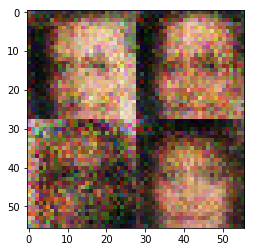

Epoch 3/10 Discriminator Loss: 0.3385  Generator Loss: -2.4398
Epoch 3/10 Discriminator Loss: 0.3385  Generator Loss: -2.4541
Epoch 3/10 Discriminator Loss: 0.4089  Generator Loss: -2.4704
Epoch 3/10 Discriminator Loss: 0.4197  Generator Loss: -2.5571
Epoch 3/10 Discriminator Loss: 1.3725  Generator Loss: -2.5605
Epoch 3/10 Discriminator Loss: 0.4074  Generator Loss: -2.5809
Epoch 3/10 Discriminator Loss: 0.4446  Generator Loss: -2.5729
Epoch 3/10 Discriminator Loss: 0.4288  Generator Loss: -2.5934
Epoch 3/10 Discriminator Loss: 0.4526  Generator Loss: -2.6085
Epoch 3/10 Discriminator Loss: 0.6100  Generator Loss: -2.6139
Epoch 3/10 Discriminator Loss: 0.5373  Generator Loss: -2.6268
Epoch 3/10 Discriminator Loss: 0.4528  Generator Loss: -2.6144
Epoch 3/10 Discriminator Loss: 0.4326  Generator Loss: -2.6328
Epoch 3/10 Discriminator Loss: 0.3771  Generator Loss: -2.5992
Epoch 3/10 Discriminator Loss: 0.3082  Generator Loss: -2.5883
Epoch 3/10 Discriminator Loss: 0.3128  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.4257  Generator Loss: -2.4587
Epoch 3/10 Discriminator Loss: 0.2591  Generator Loss: -2.4326
Epoch 3/10 Discriminator Loss: 0.6643  Generator Loss: -2.4521
Epoch 3/10 Discriminator Loss: 0.7862  Generator Loss: -2.4951
Epoch 3/10 Discriminator Loss: 0.2696  Generator Loss: -2.4836
Epoch 3/10 Discriminator Loss: 0.2097  Generator Loss: -2.4712
Epoch 3/10 Discriminator Loss: 0.3031  Generator Loss: -2.4789
Epoch 3/10 Discriminator Loss: 0.2346  Generator Loss: -2.5071
Epoch 3/10 Discriminator Loss: 0.2935  Generator Loss: -2.4887
Epoch 3/10 Discriminator Loss: 0.1616  Generator Loss: -2.4910
Epoch 3/10 Discriminator Loss: 0.1104  Generator Loss: -2.4973
Epoch 3/10 Discriminator Loss: 0.2013  Generator Loss: -2.4975
Epoch 3/10 Discriminator Loss: 0.1358  Generator Loss: -2.5151
Epoch 3/10 Discriminator Loss: 0.1433  Generator Loss: -2.5419
Epoch 3/10 Discriminator Loss: 0.0978  Generator Loss: -2.5545
Epoch 3/10 Discriminator Loss: 0.2128  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.3426  Generator Loss: -2.7447
Epoch 3/10 Discriminator Loss: 0.2598  Generator Loss: -2.7286
Epoch 3/10 Discriminator Loss: 0.2053  Generator Loss: -2.6960
Epoch 3/10 Discriminator Loss: 0.2384  Generator Loss: -2.6726
Epoch 3/10 Discriminator Loss: 0.1717  Generator Loss: -2.6598
Epoch 3/10 Discriminator Loss: 0.1869  Generator Loss: -2.6340
Epoch 3/10 Discriminator Loss: 0.2126  Generator Loss: -2.6397
Epoch 3/10 Discriminator Loss: 0.2525  Generator Loss: -2.6423
Epoch 3/10 Discriminator Loss: 0.1568  Generator Loss: -2.6181
Epoch 3/10 Discriminator Loss: 0.1951  Generator Loss: -2.6341
Epoch 3/10 Discriminator Loss: 0.2163  Generator Loss: -2.6218
Epoch 3/10 Discriminator Loss: 0.1625  Generator Loss: -2.6039
Epoch 3/10 Discriminator Loss: 0.2293  Generator Loss: -2.6437
Epoch 3/10 Discriminator Loss: 0.2703  Generator Loss: -2.6211
Epoch 3/10 Discriminator Loss: 0.2766  Generator Loss: -2.6259
Epoch 3/10 Discriminator Loss: 0.2360  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.7552  Generator Loss: -2.4019
Epoch 3/10 Discriminator Loss: 0.4309  Generator Loss: -2.3770
Epoch 3/10 Discriminator Loss: 0.2506  Generator Loss: -2.3775
Epoch 3/10 Discriminator Loss: 0.3654  Generator Loss: -2.4240
Epoch 3/10 Discriminator Loss: 0.2262  Generator Loss: -2.3939
Epoch 3/10 Discriminator Loss: 0.3916  Generator Loss: -2.4158
Epoch 3/10 Discriminator Loss: 0.5254  Generator Loss: -2.4276
Epoch 3/10 Discriminator Loss: 0.5627  Generator Loss: -2.4280
Epoch 3/10 Discriminator Loss: 0.2059  Generator Loss: -2.4434
Epoch 3/10 Discriminator Loss: 0.2373  Generator Loss: -2.4481
Epoch 3/10 Discriminator Loss: 0.1395  Generator Loss: -2.4647
Epoch 3/10 Discriminator Loss: 0.2126  Generator Loss: -2.4764
Epoch 3/10 Discriminator Loss: 0.0984  Generator Loss: -2.4869
Epoch 3/10 Discriminator Loss: 0.1164  Generator Loss: -2.5110
Epoch 3/10 Discriminator Loss: 0.2258  Generator Loss: -2.5587
Epoch 3/10 Discriminator Loss: 0.1020  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.4280  Generator Loss: -2.4744
Epoch 3/10 Discriminator Loss: 0.7948  Generator Loss: -2.4756
Epoch 3/10 Discriminator Loss: 0.1797  Generator Loss: -2.4413
Epoch 3/10 Discriminator Loss: 0.2732  Generator Loss: -2.5136
Epoch 3/10 Discriminator Loss: 0.7516  Generator Loss: -2.5172
Epoch 3/10 Discriminator Loss: 0.1833  Generator Loss: -2.5642
Epoch 3/10 Discriminator Loss: 0.1868  Generator Loss: -2.5988
Epoch 3/10 Discriminator Loss: 0.1986  Generator Loss: -2.6512
Epoch 3/10 Discriminator Loss: 0.1696  Generator Loss: -2.6775
Epoch 3/10 Discriminator Loss: 0.2166  Generator Loss: -2.6928
Epoch 3/10 Discriminator Loss: 0.2657  Generator Loss: -2.7708
Epoch 3/10 Discriminator Loss: 0.2553  Generator Loss: -2.8208
Epoch 3/10 Discriminator Loss: 0.3177  Generator Loss: -2.8462
Epoch 3/10 Discriminator Loss: 0.2128  Generator Loss: -2.8233
Epoch 3/10 Discriminator Loss: 0.3606  Generator Loss: -2.8801
Epoch 3/10 Discriminator Loss: 0.2327  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2418  Generator Loss: -2.6645
Epoch 3/10 Discriminator Loss: 0.2507  Generator Loss: -2.6995
Epoch 3/10 Discriminator Loss: 0.2286  Generator Loss: -2.7200
Epoch 3/10 Discriminator Loss: 0.2313  Generator Loss: -2.7464
Epoch 3/10 Discriminator Loss: 0.2334  Generator Loss: -2.7528
Epoch 3/10 Discriminator Loss: 0.2418  Generator Loss: -2.7787
Epoch 3/10 Discriminator Loss: 0.6149  Generator Loss: -2.8668
Epoch 3/10 Discriminator Loss: 0.3873  Generator Loss: -2.8457
Epoch 3/10 Discriminator Loss: 0.2630  Generator Loss: -2.8673
Epoch 3/10 Discriminator Loss: 0.4401  Generator Loss: -2.9459
Epoch 3/10 Discriminator Loss: 0.2721  Generator Loss: -2.9087
Epoch 3/10 Discriminator Loss: 0.6132  Generator Loss: -2.9285
Epoch 3/10 Discriminator Loss: 0.3195  Generator Loss: -2.9354
Epoch 3/10 Discriminator Loss: 0.2219  Generator Loss: -2.9011
Epoch 3/10 Discriminator Loss: 0.3024  Generator Loss: -2.9198
Epoch 3/10 Discriminator Loss: 0.2620  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2676  Generator Loss: -2.8440
Epoch 3/10 Discriminator Loss: 0.2991  Generator Loss: -2.8227
Epoch 3/10 Discriminator Loss: 0.2832  Generator Loss: -2.8364
Epoch 3/10 Discriminator Loss: 0.3449  Generator Loss: -2.8386
Epoch 3/10 Discriminator Loss: 0.2458  Generator Loss: -2.8342
Epoch 3/10 Discriminator Loss: 0.2668  Generator Loss: -2.8410
Epoch 3/10 Discriminator Loss: 0.2460  Generator Loss: -2.8171
Epoch 3/10 Discriminator Loss: 0.2355  Generator Loss: -2.8301
Epoch 3/10 Discriminator Loss: 0.2444  Generator Loss: -2.8077
Epoch 3/10 Discriminator Loss: 0.2263  Generator Loss: -2.8045
Epoch 3/10 Discriminator Loss: 0.2421  Generator Loss: -2.8075
Epoch 3/10 Discriminator Loss: 0.2040  Generator Loss: -2.7812
Epoch 3/10 Discriminator Loss: 0.2214  Generator Loss: -2.7678
Epoch 3/10 Discriminator Loss: 0.3502  Generator Loss: -2.7597
Epoch 3/10 Discriminator Loss: 0.2947  Generator Loss: -2.7536
Epoch 3/10 Discriminator Loss: 0.3020  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2213  Generator Loss: -2.6102
Epoch 3/10 Discriminator Loss: 0.3368  Generator Loss: -2.5968
Epoch 3/10 Discriminator Loss: 0.2695  Generator Loss: -2.5859
Epoch 3/10 Discriminator Loss: 0.2298  Generator Loss: -2.5832
Epoch 3/10 Discriminator Loss: 0.2255  Generator Loss: -2.5768
Epoch 3/10 Discriminator Loss: 0.2284  Generator Loss: -2.5565
Epoch 3/10 Discriminator Loss: 0.2329  Generator Loss: -2.5265
Epoch 3/10 Discriminator Loss: 0.2126  Generator Loss: -2.5216
Epoch 3/10 Discriminator Loss: 0.3076  Generator Loss: -2.4967
Epoch 3/10 Discriminator Loss: 0.2168  Generator Loss: -2.4863
Epoch 3/10 Discriminator Loss: 0.2301  Generator Loss: -2.4881
Epoch 3/10 Discriminator Loss: 0.2330  Generator Loss: -2.4866
Epoch 3/10 Discriminator Loss: 0.2270  Generator Loss: -2.4561
Epoch 3/10 Discriminator Loss: 0.3348  Generator Loss: -2.4653
Epoch 3/10 Discriminator Loss: 0.2334  Generator Loss: -2.4452
Epoch 3/10 Discriminator Loss: 0.2274  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2580  Generator Loss: -2.4560
Epoch 3/10 Discriminator Loss: 0.2019  Generator Loss: -2.4544
Epoch 3/10 Discriminator Loss: 0.2596  Generator Loss: -2.4568
Epoch 3/10 Discriminator Loss: 0.4107  Generator Loss: -2.4372
Epoch 3/10 Discriminator Loss: 0.1934  Generator Loss: -2.4452
Epoch 3/10 Discriminator Loss: 0.2107  Generator Loss: -2.4586
Epoch 3/10 Discriminator Loss: 0.2008  Generator Loss: -2.4996
Epoch 3/10 Discriminator Loss: 0.3491  Generator Loss: -2.4851
Epoch 3/10 Discriminator Loss: 0.2228  Generator Loss: -2.5113
Epoch 3/10 Discriminator Loss: 0.2696  Generator Loss: -2.5236
Epoch 3/10 Discriminator Loss: 0.2848  Generator Loss: -2.4984
Epoch 3/10 Discriminator Loss: 0.2767  Generator Loss: -2.5274
Epoch 3/10 Discriminator Loss: 0.2056  Generator Loss: -2.5532
Epoch 3/10 Discriminator Loss: 0.2683  Generator Loss: -2.5592
Epoch 3/10 Discriminator Loss: 0.2467  Generator Loss: -2.5671
Epoch 3/10 Discriminator Loss: 0.3614  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1965  Generator Loss: -2.4734
Epoch 3/10 Discriminator Loss: 0.1474  Generator Loss: -2.4571
Epoch 3/10 Discriminator Loss: 0.2313  Generator Loss: -2.4345
Epoch 3/10 Discriminator Loss: 0.1760  Generator Loss: -2.4169
Epoch 3/10 Discriminator Loss: 0.1132  Generator Loss: -2.4374
Epoch 3/10 Discriminator Loss: 0.3632  Generator Loss: -2.4325
Epoch 3/10 Discriminator Loss: 0.5958  Generator Loss: -2.4183
Epoch 3/10 Discriminator Loss: 0.1903  Generator Loss: -2.4323
Epoch 3/10 Discriminator Loss: 0.3845  Generator Loss: -2.3907
Epoch 3/10 Discriminator Loss: 0.1770  Generator Loss: -2.4208
Epoch 3/10 Discriminator Loss: 0.2762  Generator Loss: -2.4345
Epoch 3/10 Discriminator Loss: 0.2385  Generator Loss: -2.4735
Epoch 3/10 Discriminator Loss: 0.2705  Generator Loss: -2.5211
Epoch 3/10 Discriminator Loss: 0.3726  Generator Loss: -2.4970
Epoch 3/10 Discriminator Loss: 0.3133  Generator Loss: -2.5620
Epoch 3/10 Discriminator Loss: 0.3780  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.2896  Generator Loss: -2.5419
Epoch 3/10 Discriminator Loss: 0.2993  Generator Loss: -2.5638
Epoch 3/10 Discriminator Loss: 0.2723  Generator Loss: -2.5495
Epoch 3/10 Discriminator Loss: 0.2657  Generator Loss: -2.5449
Epoch 3/10 Discriminator Loss: 0.1959  Generator Loss: -2.5048
Epoch 3/10 Discriminator Loss: 0.1753  Generator Loss: -2.4815
Epoch 3/10 Discriminator Loss: 0.2349  Generator Loss: -2.4536
Epoch 3/10 Discriminator Loss: 0.1258  Generator Loss: -2.4453
Epoch 3/10 Discriminator Loss: 0.1006  Generator Loss: -2.4268
Epoch 3/10 Discriminator Loss: 0.2032  Generator Loss: -2.4264
Epoch 3/10 Discriminator Loss: 0.1557  Generator Loss: -2.4323
Epoch 3/10 Discriminator Loss: 0.0698  Generator Loss: -2.4027
Epoch 3/10 Discriminator Loss: 0.1520  Generator Loss: -2.4567
Epoch 3/10 Discriminator Loss: 0.1535  Generator Loss: -2.4923
Epoch 3/10 Discriminator Loss: 0.2465  Generator Loss: -2.4994
Epoch 3/10 Discriminator Loss: 0.1813  Generator Loss: 

Epoch 3/10 Discriminator Loss: 0.1021  Generator Loss: -2.6396
Epoch 3/10 Discriminator Loss: 0.1539  Generator Loss: -2.6573
Epoch 3/10 Discriminator Loss: 0.0816  Generator Loss: -2.6273
Epoch 3/10 Discriminator Loss: 0.1533  Generator Loss: -2.6837
Epoch 3/10 Discriminator Loss: 0.2939  Generator Loss: -2.7619
Epoch 3/10 Discriminator Loss: 0.2644  Generator Loss: -2.7457
Epoch 3/10 Discriminator Loss: 0.2467  Generator Loss: -2.7780
Epoch 3/10 Discriminator Loss: 0.3982  Generator Loss: -2.7812
Epoch 3/10 Discriminator Loss: 0.3036  Generator Loss: -2.8154
Epoch 3/10 Discriminator Loss: 0.2708  Generator Loss: -2.8078
Epoch 3/10 Discriminator Loss: 0.2963  Generator Loss: -2.8675
Epoch 3/10 Discriminator Loss: 0.4998  Generator Loss: -2.8134
Epoch 3/10 Discriminator Loss: 0.3584  Generator Loss: -2.8393
Epoch 3/10 Discriminator Loss: 0.3137  Generator Loss: -2.8340
Epoch 3/10 Discriminator Loss: 0.2893  Generator Loss: -2.7908
Epoch 3/10 Discriminator Loss: 0.4624  Generator Loss: 

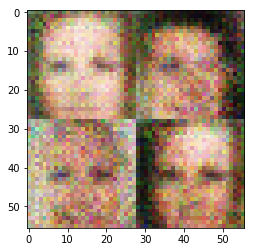

Epoch 4/10 Discriminator Loss: 0.2037  Generator Loss: -2.6203
Epoch 4/10 Discriminator Loss: 0.1569  Generator Loss: -2.6285
Epoch 4/10 Discriminator Loss: 0.1490  Generator Loss: -2.6293
Epoch 4/10 Discriminator Loss: 0.1810  Generator Loss: -2.6223
Epoch 4/10 Discriminator Loss: 0.2590  Generator Loss: -2.6085
Epoch 4/10 Discriminator Loss: 0.2086  Generator Loss: -2.6053
Epoch 4/10 Discriminator Loss: 0.1614  Generator Loss: -2.5965
Epoch 4/10 Discriminator Loss: 0.2059  Generator Loss: -2.6081
Epoch 4/10 Discriminator Loss: 0.2166  Generator Loss: -2.5824
Epoch 4/10 Discriminator Loss: 0.2633  Generator Loss: -2.5603
Epoch 4/10 Discriminator Loss: 0.2846  Generator Loss: -2.5490
Epoch 4/10 Discriminator Loss: 0.1373  Generator Loss: -2.5352
Epoch 4/10 Discriminator Loss: 0.1987  Generator Loss: -2.5393
Epoch 4/10 Discriminator Loss: 0.1823  Generator Loss: -2.5085
Epoch 4/10 Discriminator Loss: 0.1489  Generator Loss: -2.4827
Epoch 4/10 Discriminator Loss: 0.1424  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.2289  Generator Loss: -2.4655
Epoch 4/10 Discriminator Loss: 0.1748  Generator Loss: -2.4627
Epoch 4/10 Discriminator Loss: 0.1533  Generator Loss: -2.4529
Epoch 4/10 Discriminator Loss: 0.1734  Generator Loss: -2.4763
Epoch 4/10 Discriminator Loss: 0.1942  Generator Loss: -2.4819
Epoch 4/10 Discriminator Loss: 0.2620  Generator Loss: -2.4881
Epoch 4/10 Discriminator Loss: 0.1703  Generator Loss: -2.5011
Epoch 4/10 Discriminator Loss: 0.1175  Generator Loss: -2.4970
Epoch 4/10 Discriminator Loss: 0.1307  Generator Loss: -2.5080
Epoch 4/10 Discriminator Loss: 0.1267  Generator Loss: -2.5275
Epoch 4/10 Discriminator Loss: 0.1845  Generator Loss: -2.5488
Epoch 4/10 Discriminator Loss: 0.1312  Generator Loss: -2.5630
Epoch 4/10 Discriminator Loss: 0.1497  Generator Loss: -2.5609
Epoch 4/10 Discriminator Loss: 0.1397  Generator Loss: -2.5532
Epoch 4/10 Discriminator Loss: 0.1670  Generator Loss: -2.6076
Epoch 4/10 Discriminator Loss: 0.1696  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.2585  Generator Loss: -2.6603
Epoch 4/10 Discriminator Loss: 0.3079  Generator Loss: -2.7286
Epoch 4/10 Discriminator Loss: 0.2753  Generator Loss: -2.7248
Epoch 4/10 Discriminator Loss: 0.3111  Generator Loss: -2.7311
Epoch 4/10 Discriminator Loss: 0.3131  Generator Loss: -2.7327
Epoch 4/10 Discriminator Loss: 0.2792  Generator Loss: -2.7324
Epoch 4/10 Discriminator Loss: 0.3122  Generator Loss: -2.7126
Epoch 4/10 Discriminator Loss: 0.2388  Generator Loss: -2.6756
Epoch 4/10 Discriminator Loss: 0.2891  Generator Loss: -2.6578
Epoch 4/10 Discriminator Loss: 0.1925  Generator Loss: -2.6155
Epoch 4/10 Discriminator Loss: 0.1576  Generator Loss: -2.5475
Epoch 4/10 Discriminator Loss: 0.2176  Generator Loss: -2.6392
Epoch 4/10 Discriminator Loss: 0.1909  Generator Loss: -2.6190
Epoch 4/10 Discriminator Loss: 0.2671  Generator Loss: -2.6495
Epoch 4/10 Discriminator Loss: 0.2377  Generator Loss: -2.6466
Epoch 4/10 Discriminator Loss: 0.4127  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1764  Generator Loss: -2.5847
Epoch 4/10 Discriminator Loss: 0.0711  Generator Loss: -2.5908
Epoch 4/10 Discriminator Loss: 0.1643  Generator Loss: -2.5686
Epoch 4/10 Discriminator Loss: 0.1316  Generator Loss: -2.5485
Epoch 4/10 Discriminator Loss: 0.0912  Generator Loss: -2.5703
Epoch 4/10 Discriminator Loss: 0.2532  Generator Loss: -2.5650
Epoch 4/10 Discriminator Loss: 0.1618  Generator Loss: -2.6167
Epoch 4/10 Discriminator Loss: 0.2060  Generator Loss: -2.6393
Epoch 4/10 Discriminator Loss: 0.1894  Generator Loss: -2.6257
Epoch 4/10 Discriminator Loss: 0.1806  Generator Loss: -2.6425
Epoch 4/10 Discriminator Loss: 0.2732  Generator Loss: -2.6549
Epoch 4/10 Discriminator Loss: 0.1817  Generator Loss: -2.6455
Epoch 4/10 Discriminator Loss: 0.1970  Generator Loss: -2.6612
Epoch 4/10 Discriminator Loss: 0.1597  Generator Loss: -2.6408
Epoch 4/10 Discriminator Loss: 0.1752  Generator Loss: -2.6483
Epoch 4/10 Discriminator Loss: 0.1587  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.3643  Generator Loss: -2.7006
Epoch 4/10 Discriminator Loss: 0.2460  Generator Loss: -2.6965
Epoch 4/10 Discriminator Loss: 0.2584  Generator Loss: -2.7216
Epoch 4/10 Discriminator Loss: 0.4315  Generator Loss: -2.7260
Epoch 4/10 Discriminator Loss: 0.2368  Generator Loss: -2.7453
Epoch 4/10 Discriminator Loss: 0.2644  Generator Loss: -2.7417
Epoch 4/10 Discriminator Loss: 0.2827  Generator Loss: -2.7391
Epoch 4/10 Discriminator Loss: 0.2686  Generator Loss: -2.7345
Epoch 4/10 Discriminator Loss: 0.3745  Generator Loss: -2.7601
Epoch 4/10 Discriminator Loss: 0.2835  Generator Loss: -2.7528
Epoch 4/10 Discriminator Loss: 0.2975  Generator Loss: -2.7311
Epoch 4/10 Discriminator Loss: 0.2406  Generator Loss: -2.7483
Epoch 4/10 Discriminator Loss: 0.2423  Generator Loss: -2.7451
Epoch 4/10 Discriminator Loss: 0.2816  Generator Loss: -2.7342
Epoch 4/10 Discriminator Loss: 0.2320  Generator Loss: -2.7123
Epoch 4/10 Discriminator Loss: 0.4295  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1839  Generator Loss: -2.3963
Epoch 4/10 Discriminator Loss: 0.1986  Generator Loss: -2.3847
Epoch 4/10 Discriminator Loss: 0.8099  Generator Loss: -2.3438
Epoch 4/10 Discriminator Loss: 1.0081  Generator Loss: -2.3398
Epoch 4/10 Discriminator Loss: 0.1111  Generator Loss: -2.3326
Epoch 4/10 Discriminator Loss: 0.2584  Generator Loss: -2.3274
Epoch 4/10 Discriminator Loss: 0.8368  Generator Loss: -2.3939
Epoch 4/10 Discriminator Loss: 0.6908  Generator Loss: -2.3855
Epoch 4/10 Discriminator Loss: 1.9071  Generator Loss: -2.3963
Epoch 4/10 Discriminator Loss: 0.4041  Generator Loss: -2.4066
Epoch 4/10 Discriminator Loss: 0.6004  Generator Loss: -2.4955
Epoch 4/10 Discriminator Loss: 1.0564  Generator Loss: -2.4688
Epoch 4/10 Discriminator Loss: 0.8338  Generator Loss: -2.6025
Epoch 4/10 Discriminator Loss: 0.3716  Generator Loss: -2.6385
Epoch 4/10 Discriminator Loss: 0.4201  Generator Loss: -2.6436
Epoch 4/10 Discriminator Loss: 0.3595  Generator Loss: 

Epoch 4/10 Discriminator Loss: 2.1441  Generator Loss: -2.3820
Epoch 4/10 Discriminator Loss: 1.2169  Generator Loss: -2.4250
Epoch 4/10 Discriminator Loss: 1.1565  Generator Loss: -2.4463
Epoch 4/10 Discriminator Loss: 0.3184  Generator Loss: -2.4559
Epoch 4/10 Discriminator Loss: 0.1983  Generator Loss: -2.5102
Epoch 4/10 Discriminator Loss: 0.3019  Generator Loss: -2.5195
Epoch 4/10 Discriminator Loss: 0.3519  Generator Loss: -2.5430
Epoch 4/10 Discriminator Loss: 0.4212  Generator Loss: -2.5477
Epoch 4/10 Discriminator Loss: 0.1908  Generator Loss: -2.5553
Epoch 4/10 Discriminator Loss: 0.2423  Generator Loss: -2.6103
Epoch 4/10 Discriminator Loss: 0.2227  Generator Loss: -2.6233
Epoch 4/10 Discriminator Loss: 0.2089  Generator Loss: -2.6342
Epoch 4/10 Discriminator Loss: 0.2023  Generator Loss: -2.6697
Epoch 4/10 Discriminator Loss: 0.3379  Generator Loss: -2.6197
Epoch 4/10 Discriminator Loss: 0.2201  Generator Loss: -2.7021
Epoch 4/10 Discriminator Loss: 0.3522  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.2023  Generator Loss: -2.9109
Epoch 4/10 Discriminator Loss: 0.3763  Generator Loss: -2.9344
Epoch 4/10 Discriminator Loss: 0.3768  Generator Loss: -2.9408
Epoch 4/10 Discriminator Loss: 0.2479  Generator Loss: -2.9738
Epoch 4/10 Discriminator Loss: 0.1925  Generator Loss: -2.9230
Epoch 4/10 Discriminator Loss: 0.4965  Generator Loss: -2.9760
Epoch 4/10 Discriminator Loss: 0.2042  Generator Loss: -2.9645
Epoch 4/10 Discriminator Loss: 0.2172  Generator Loss: -2.9349
Epoch 4/10 Discriminator Loss: 0.2115  Generator Loss: -2.9298
Epoch 4/10 Discriminator Loss: 0.2213  Generator Loss: -2.9228
Epoch 4/10 Discriminator Loss: 0.1688  Generator Loss: -2.8606
Epoch 4/10 Discriminator Loss: 0.1453  Generator Loss: -2.8317
Epoch 4/10 Discriminator Loss: 0.1957  Generator Loss: -2.8076
Epoch 4/10 Discriminator Loss: 0.1498  Generator Loss: -2.7907
Epoch 4/10 Discriminator Loss: 0.2497  Generator Loss: -2.7633
Epoch 4/10 Discriminator Loss: 0.1656  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.3940  Generator Loss: -2.7446
Epoch 4/10 Discriminator Loss: 0.2169  Generator Loss: -2.7482
Epoch 4/10 Discriminator Loss: 0.2389  Generator Loss: -2.7523
Epoch 4/10 Discriminator Loss: 0.6393  Generator Loss: -2.7599
Epoch 4/10 Discriminator Loss: 0.3579  Generator Loss: -2.8127
Epoch 4/10 Discriminator Loss: 0.9091  Generator Loss: -2.8399
Epoch 4/10 Discriminator Loss: 0.7316  Generator Loss: -2.8265
Epoch 4/10 Discriminator Loss: 0.4689  Generator Loss: -2.8607
Epoch 4/10 Discriminator Loss: 0.4651  Generator Loss: -2.9327
Epoch 4/10 Discriminator Loss: 0.9185  Generator Loss: -2.9466
Epoch 4/10 Discriminator Loss: 0.7714  Generator Loss: -2.9670
Epoch 4/10 Discriminator Loss: 0.5116  Generator Loss: -2.8916
Epoch 4/10 Discriminator Loss: 0.3554  Generator Loss: -2.8432
Epoch 4/10 Discriminator Loss: 0.4797  Generator Loss: -2.7987
Epoch 4/10 Discriminator Loss: 0.3141  Generator Loss: -2.7455
Epoch 4/10 Discriminator Loss: 0.2402  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1865  Generator Loss: -2.7726
Epoch 4/10 Discriminator Loss: 0.1755  Generator Loss: -2.7484
Epoch 4/10 Discriminator Loss: 0.3552  Generator Loss: -2.7786
Epoch 4/10 Discriminator Loss: 0.1287  Generator Loss: -2.7969
Epoch 4/10 Discriminator Loss: 0.1834  Generator Loss: -2.7825
Epoch 4/10 Discriminator Loss: 0.1652  Generator Loss: -2.8331
Epoch 4/10 Discriminator Loss: 0.1388  Generator Loss: -2.7919
Epoch 4/10 Discriminator Loss: 0.1401  Generator Loss: -2.8422
Epoch 4/10 Discriminator Loss: 0.3740  Generator Loss: -2.8535
Epoch 4/10 Discriminator Loss: 0.6412  Generator Loss: -2.8648
Epoch 4/10 Discriminator Loss: 0.1205  Generator Loss: -2.8864
Epoch 4/10 Discriminator Loss: 0.2226  Generator Loss: -2.9244
Epoch 4/10 Discriminator Loss: 0.2959  Generator Loss: -2.9651
Epoch 4/10 Discriminator Loss: 0.6306  Generator Loss: -2.9375
Epoch 4/10 Discriminator Loss: 0.1934  Generator Loss: -2.9434
Epoch 4/10 Discriminator Loss: 0.5538  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.2543  Generator Loss: -2.7051
Epoch 4/10 Discriminator Loss: 0.3406  Generator Loss: -2.7070
Epoch 4/10 Discriminator Loss: 0.2049  Generator Loss: -2.7190
Epoch 4/10 Discriminator Loss: 0.1528  Generator Loss: -2.7105
Epoch 4/10 Discriminator Loss: 0.4555  Generator Loss: -2.7193
Epoch 4/10 Discriminator Loss: 0.5569  Generator Loss: -2.7379
Epoch 4/10 Discriminator Loss: 0.2252  Generator Loss: -2.7427
Epoch 4/10 Discriminator Loss: 0.2112  Generator Loss: -2.7513
Epoch 4/10 Discriminator Loss: 0.3285  Generator Loss: -2.7647
Epoch 4/10 Discriminator Loss: 0.1700  Generator Loss: -2.7423
Epoch 4/10 Discriminator Loss: 0.1534  Generator Loss: -2.7386
Epoch 4/10 Discriminator Loss: 0.1733  Generator Loss: -2.7369
Epoch 4/10 Discriminator Loss: 0.3088  Generator Loss: -2.7468
Epoch 4/10 Discriminator Loss: 0.7558  Generator Loss: -2.7464
Epoch 4/10 Discriminator Loss: 0.3222  Generator Loss: -2.7173
Epoch 4/10 Discriminator Loss: 0.1399  Generator Loss: 

Epoch 4/10 Discriminator Loss: 0.1204  Generator Loss: -2.8094
Epoch 4/10 Discriminator Loss: 0.4945  Generator Loss: -2.7859
Epoch 4/10 Discriminator Loss: 0.2180  Generator Loss: -2.7796
Epoch 4/10 Discriminator Loss: 0.5452  Generator Loss: -2.7446
Epoch 4/10 Discriminator Loss: 0.2314  Generator Loss: -2.7164
Epoch 4/10 Discriminator Loss: 0.2698  Generator Loss: -2.7271
Epoch 4/10 Discriminator Loss: 0.1534  Generator Loss: -2.6821
Epoch 4/10 Discriminator Loss: 0.1416  Generator Loss: -2.6700
Epoch 4/10 Discriminator Loss: 0.1173  Generator Loss: -2.6611
Epoch 4/10 Discriminator Loss: 0.1769  Generator Loss: -2.6204
Epoch 4/10 Discriminator Loss: 0.2311  Generator Loss: -2.6227
Epoch 4/10 Discriminator Loss: 0.1630  Generator Loss: -2.5825
Epoch 4/10 Discriminator Loss: 0.1761  Generator Loss: -2.5825
Epoch 4/10 Discriminator Loss: 0.1684  Generator Loss: -2.5779
Epoch 4/10 Discriminator Loss: 0.2093  Generator Loss: -2.5387
Epoch 4/10 Discriminator Loss: 0.1491  Generator Loss: 

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10
save_path = "celeba_save"


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          save_folder=save_path, base_i=3, load_path=save_path+"/2_gan.ckpt")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.